# BiLSTM으로 한국어 스팀 리뷰 감성 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 로드

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x17559f550>)

In [3]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [4]:
total_data[:10]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
5,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
6,1,재미있었습니다.
7,1,은근 쉽지만 은근 어려운 게임
8,0,베ㅈ스다 이 개^ㅐ끼들아. 시작할 때 체스판 돌아가는거 5분동안 3번 봤더나 ㅈㄴ ...
9,1,1시간 40분동안 스트레스 다 풀림 ㄹㅇ


In [5]:
# 중복 제외 샘플 수 확인
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [6]:
# 중복 샘플 제외
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [7]:
# null 값 확인
print(total_data.isnull().values.any())

False


### 데이터 분할

In [13]:
# 25% 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


In [15]:
# train data 레이블 분포 확인
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


### 데이터 정제 및 확인

In [16]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


In [17]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


In [18]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', 
             '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [19]:
# mecab을 사용해 토큰화
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [21]:
# negative
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8125), ('없', 7141), ('는데', 5729), ('있', 5690), ('같', 4251), ('로', 4171), ('할', 3931), ('거', 3903), ('나', 3818), ('해', 3650), ('너무', 3521), ('으로', 3351), ('기', 3350), ('했', 3262), ('어', 3155), ('습니다', 2962), ('지만', 2951), ('것', 2937), ('겠', 2901), ('않', 2898)]


In [23]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9985), ('좋', 6540), ('습니다', 5178), ('재밌', 4997), ('지만', 4870), ('할', 4855), ('해', 4357), ('없', 4149), ('로', 3931), ('으로', 3900), ('수', 3836), ('보', 3832), ('는데', 3767), ('기', 3591), ('안', 3374), ('것', 3367), ('같', 3356), ('네요', 3189), ('어', 3123), ('나', 3080)]


In [24]:
# 타겟값 분할
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

### 정수 인코딩

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [26]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32920
등장 빈도가 1번 이하인 희귀 단어의 수: 13905
단어 집합에서 희귀 단어의 비율: 42.23876063183475
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.227843842634659


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19017


In [28]:
# 단어 집합의 크기 만큼의 단어 사용 (나머지는 OOV 토큰으로 처리)
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
print(X_train[:3])

[[469, 635, 7, 35, 86, 149, 2417, 600, 26, 8, 70, 47, 233, 110, 38, 43, 52], [160, 300, 18, 21, 63, 3577, 985, 6, 56], [7, 16, 1477, 4]]


In [30]:
print(X_test[:3])

[[729, 34, 15, 433, 52, 106, 132, 88, 6459, 457], [4518, 689, 832, 713, 687, 109, 4, 1782, 98, 371, 3515, 81, 559, 1903, 4309, 261, 168, 61, 25, 364, 35, 86, 977, 19, 6292, 6417], [1728, 793, 567, 49, 23, 349]]


### 패딩

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.11596524246186


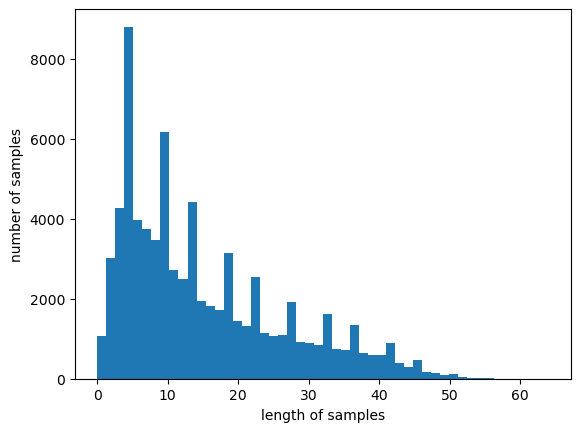

In [31]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99733045021956


In [34]:
# 길이 60으로 패딩 (max_len = 60)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### BiLSTM 감성 분석 모델

In [35]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
embedding_dim = 150
hidden_units = 128

model = Sequential() # keras에서 순차적으로 모델 쌓기
model.add(Embedding(vocab_size, embedding_dim)) # vocab_size: 단어 인덱스의 최대값, embedding_dim: 각 단어가 변환될 벡터의 차원 수
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid')) # 출력 layer (활성화 함수로 sigmoid 사용 - 이진분류)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # epoch 수가 4가 되면 훈련 조기 중단
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7017 - loss: 0.5607
Epoch 1: val_accuracy improved from -inf to 0.78811, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 154ms/step - accuracy: 0.7018 - loss: 0.5606 - val_accuracy: 0.7881 - val_loss: 0.4594
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8240 - loss: 0.3977
Epoch 2: val_accuracy did not improve from 0.78811
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - accuracy: 0.8240 - loss: 0.3977 - val_accuracy: 0.7853 - val_loss: 0.4600
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8558 - loss: 0.3397
Epoch 3: val_accuracy did not improve from 0.78811
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 165ms/step - accuracy: 0.8558 - loss: 0.3397 - val_accuracy: 0.7810 - val_loss: 0.4870
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8804 - loss: 0.2854
Epoch 4: val_accuracy did not improve from 0.78811
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - acc

In [43]:
loaded_model = load_model('best_model.keras')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7815 - loss: 0.4652
테스트 정확도: 0.7855


### 예측

In [44]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [45]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
88.24% 확률로 부정 리뷰입니다.


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_53336/2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [48]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
90.05% 확률로 긍정 리뷰입니다.


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_53336/2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [52]:
sentiment_predict('케릭터가 예뻐서 조아요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
75.83% 확률로 긍정 리뷰입니다.


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_53336/2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
